# PBMC cycloheximide experiment

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import bbknn
import scipy.stats
import statsmodels
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import joblib
import glob
import scrublet as scr

# import putils
import sys
sys.path.append('/home/jovyan/chenqu_utils')
from array_operations import *

#sklearn <- machine learning
#statsmodels

# importing scjp
%load_ext autoreload
%autoreload 2
sys.path.append('/home/jovyan/thymusatlas/')
import scjp
import joblib as jl

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]

In [2]:
sb.set_palette('colorblind')

In [3]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [4]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [5]:
# printing version
version = 'PBMC.A01.v01.'

## Download dataset

In [6]:
# define sample dict
smp_dict = pd.read_csv('csv/PBMC_cycloheximide_23082022.txt', delimiter='/t', header=None)
smp_dict = list(smp_dict[0])

<ipython-input-6-2ed9f102f2b6>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  smp_dict = pd.read_csv('PBMC_cycloheximide_23082022.txt', delimiter='/t', header=None)


In [7]:
# check whether all files have been downloaded in matrix folder
DATAFOLDER = '/lustre/scratch117/cellgen/team205/cs42/VDJ_colab/matrix/'
exist = [x.split('/')[-1] for x in glob.glob(DATAFOLDER+'*')]

if len([x for x in smp_dict if x not in exist])>0:
    print([smp_dict[x][2] for x in smp_dict if x not in exist],'not in matrix folder')

In [5]:
# load manifest
manifest = pd.read_csv('metadata/PBMC_manifest.csv')

In [6]:
manifest

,Donor,organ,age,Date_of_sample,Sample,10x kit,target_recovery,cells_loaded,sample_no,sanger_sample_ID,sequence_name,BCR,TCR
0,Stemcells,PBMC,adult,19/07/2022,AM1_treated,5'v2.0,10000,17653,1,AM1_treated,HCA_F_Imm13086136,HCA_F_Imm13086148,HCA_F_Imm13086142
1,Stemcells,PBMC,adult,19/07/2022,AM1_control,5'v2.0,10000,16698,2,AM1_control,HCA_F_Imm13086137,HCA_F_Imm13086149,HCA_F_Imm13086143


In [9]:
def read_files(filename, raw_file_path = '/lustre/scratch117/cellgen/team205/cs42/VDJ_colab/matrix',
               min_n_count = 2000, min_n_gene = 500, max_ne_gene = 7000):

    path = '%s/%s/raw/'%(raw_file_path,filename)
    adata = sc.read_10x_mtx(path)
    
    adata.obs_names = [filename+"-"+x.strip("-1") for x in adata.obs_names]
    
    # caculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)
    
    # calculate mito
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    
    # filter cells
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > 2000))
    clist.append(np.array(adata.obs['n_genes'] > 500))
    clist.append(np.array(adata.obs['n_genes'] < 7000))
    clist.append(np.array(adata.obs['mito'] < 0.2)) # filter out mito >= 0.2
    
    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()
    
    # update manifest onto .obs
    adata.obs['file'] = filename
    adata.obs['sanger_sample_ID'] = list(manifest.loc[manifest['sequence_name']==filename,'sanger_sample_ID'])[0]
    
    # calculate doublets using scrublet
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    
    sc.write('%s_filtered'%(filename),adata)

In [10]:
from multiprocessing import Pool

with Pool(10) as p:
    p.map(read_files, [x for x in smp_dict])

<ipython-input-9-d1916f73ecd0>:15: RuntimeWarning: invalid value encountered in true_divide
  adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
<ipython-input-9-d1916f73ecd0>:15: RuntimeWarning: invalid value encountered in true_divide
  adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)


KeyboardInterrupt: 

## Merge dataset

In [ ]:
ad = {}

In [ ]:
for filename in smp_dict:
    ad[filename] = sc.read('%s_filtered'%(filename))

In [ ]:
merged = scjp.merge_matrix(ad)

In [ ]:
merged.obs.head(3)

In [ ]:
merged.var_names_make_unique()

## Preprocessing - normalise and log

In [ ]:
sc.pp.normalize_per_cell(merged,counts_per_cell_after=10e4)

In [ ]:
sc.pp.log1p(merged)

In [ ]:
scjp.write(merged,version,'entire_data_normalised_log')

In [ ]:
merged = sc.read('write/PBMC.A01.v01.entire_data_normalised_log.h5ad')

## Checking the contents of data

In [ ]:
Counter(merged.obs['file'])

# Load data (normalised and log transformed)

In [11]:
merged = sc.read('write/PBMC.A01.v01.entire_data_normalised_log.h5ad')

Only considering the two last: ['.entire_data_normalised_log', '.h5ad'].
Only considering the two last: ['.entire_data_normalised_log', '.h5ad'].


In [12]:
merged.raw = merged

In [13]:
merged_raw = merged.copy() # keep unfiltered dataset

# build UMAP and leiden clustering

In [14]:
adata = merged.copy()
#sc.pp.filter_genes(adata, min_cells = 3)

######## remove all predicted doublets and doublet_scores > 0.5 (35929 cells -> 35651 cells) 

In [15]:
adata = adata[~adata.obs['predicted_doublets']]

In [16]:
#plt.hist(adata[adata.obs['doublet_scores']>0.2].obs['doublet_scores'])

In [17]:
adata = adata[~(adata.obs['doublet_scores']> 0.5)]

###############

In [18]:
np.median(adata.obs['n_genes'])

2609.0

In [19]:
sc.pp.highly_variable_genes(adata)
#sc.pl.highly_variable_genes(adata)

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [20]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata, random_state = 1712)

### Annotation prediction with celltypist

In [21]:
import celltypist
from celltypist import models

In [22]:
celltypist.__version__

'1.2.0'

In [23]:
adata_new=adata.copy()
#adata_new.var.index = adata_new.var['gene_names']
sc.pp.normalize_per_cell(adata_new,counts_per_cell_after=1e4,key_n_counts='total_counts')
sc.pp.log1p(adata_new)

In [24]:
adata_new.raw = adata_new.copy()

In [25]:
celltypist.models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 12
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/12]: Immune_All_Low.pkl
💾 Downloading model [2/12]: Immune_All_High.pkl
💾 Downloading model [3/12]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/12]: COVID19_Immune_Landscape.pkl
💾 Downloading model [5/12]: Cells_Fetal_Lung.pkl
💾 Downloading model [6/12]: Cells_Intestinal_Tract.pkl
💾 Downloading model [7/12]: Cells_Lung_Airway.pkl
💾 Downloading model [8/12]: Developing_Mouse_Brain.pkl
💾 Downloading model [9/12]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [10/12]: Human_Lung_Atlas.pkl
💾 Downloading model [11/12]: Nuclei_Lung_Airway.pkl
💾 Downloading model [12/12]: Pan_Fetal_Human.pkl


In [26]:
predictions = celltypist.annotate(adata_new, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 15605 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 5967 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [28]:
adata_new = predictions.to_adata()

In [29]:
adata_new.write_h5ad('write/PBMC_cycloheximide_predictions.h5ad')

In [6]:
adata = sc.read('write/PBMC_cycloheximide_predictions.h5ad')

In [31]:
adata.obs.to_csv('csv/PBMC_cycloheximide_obs.csv')

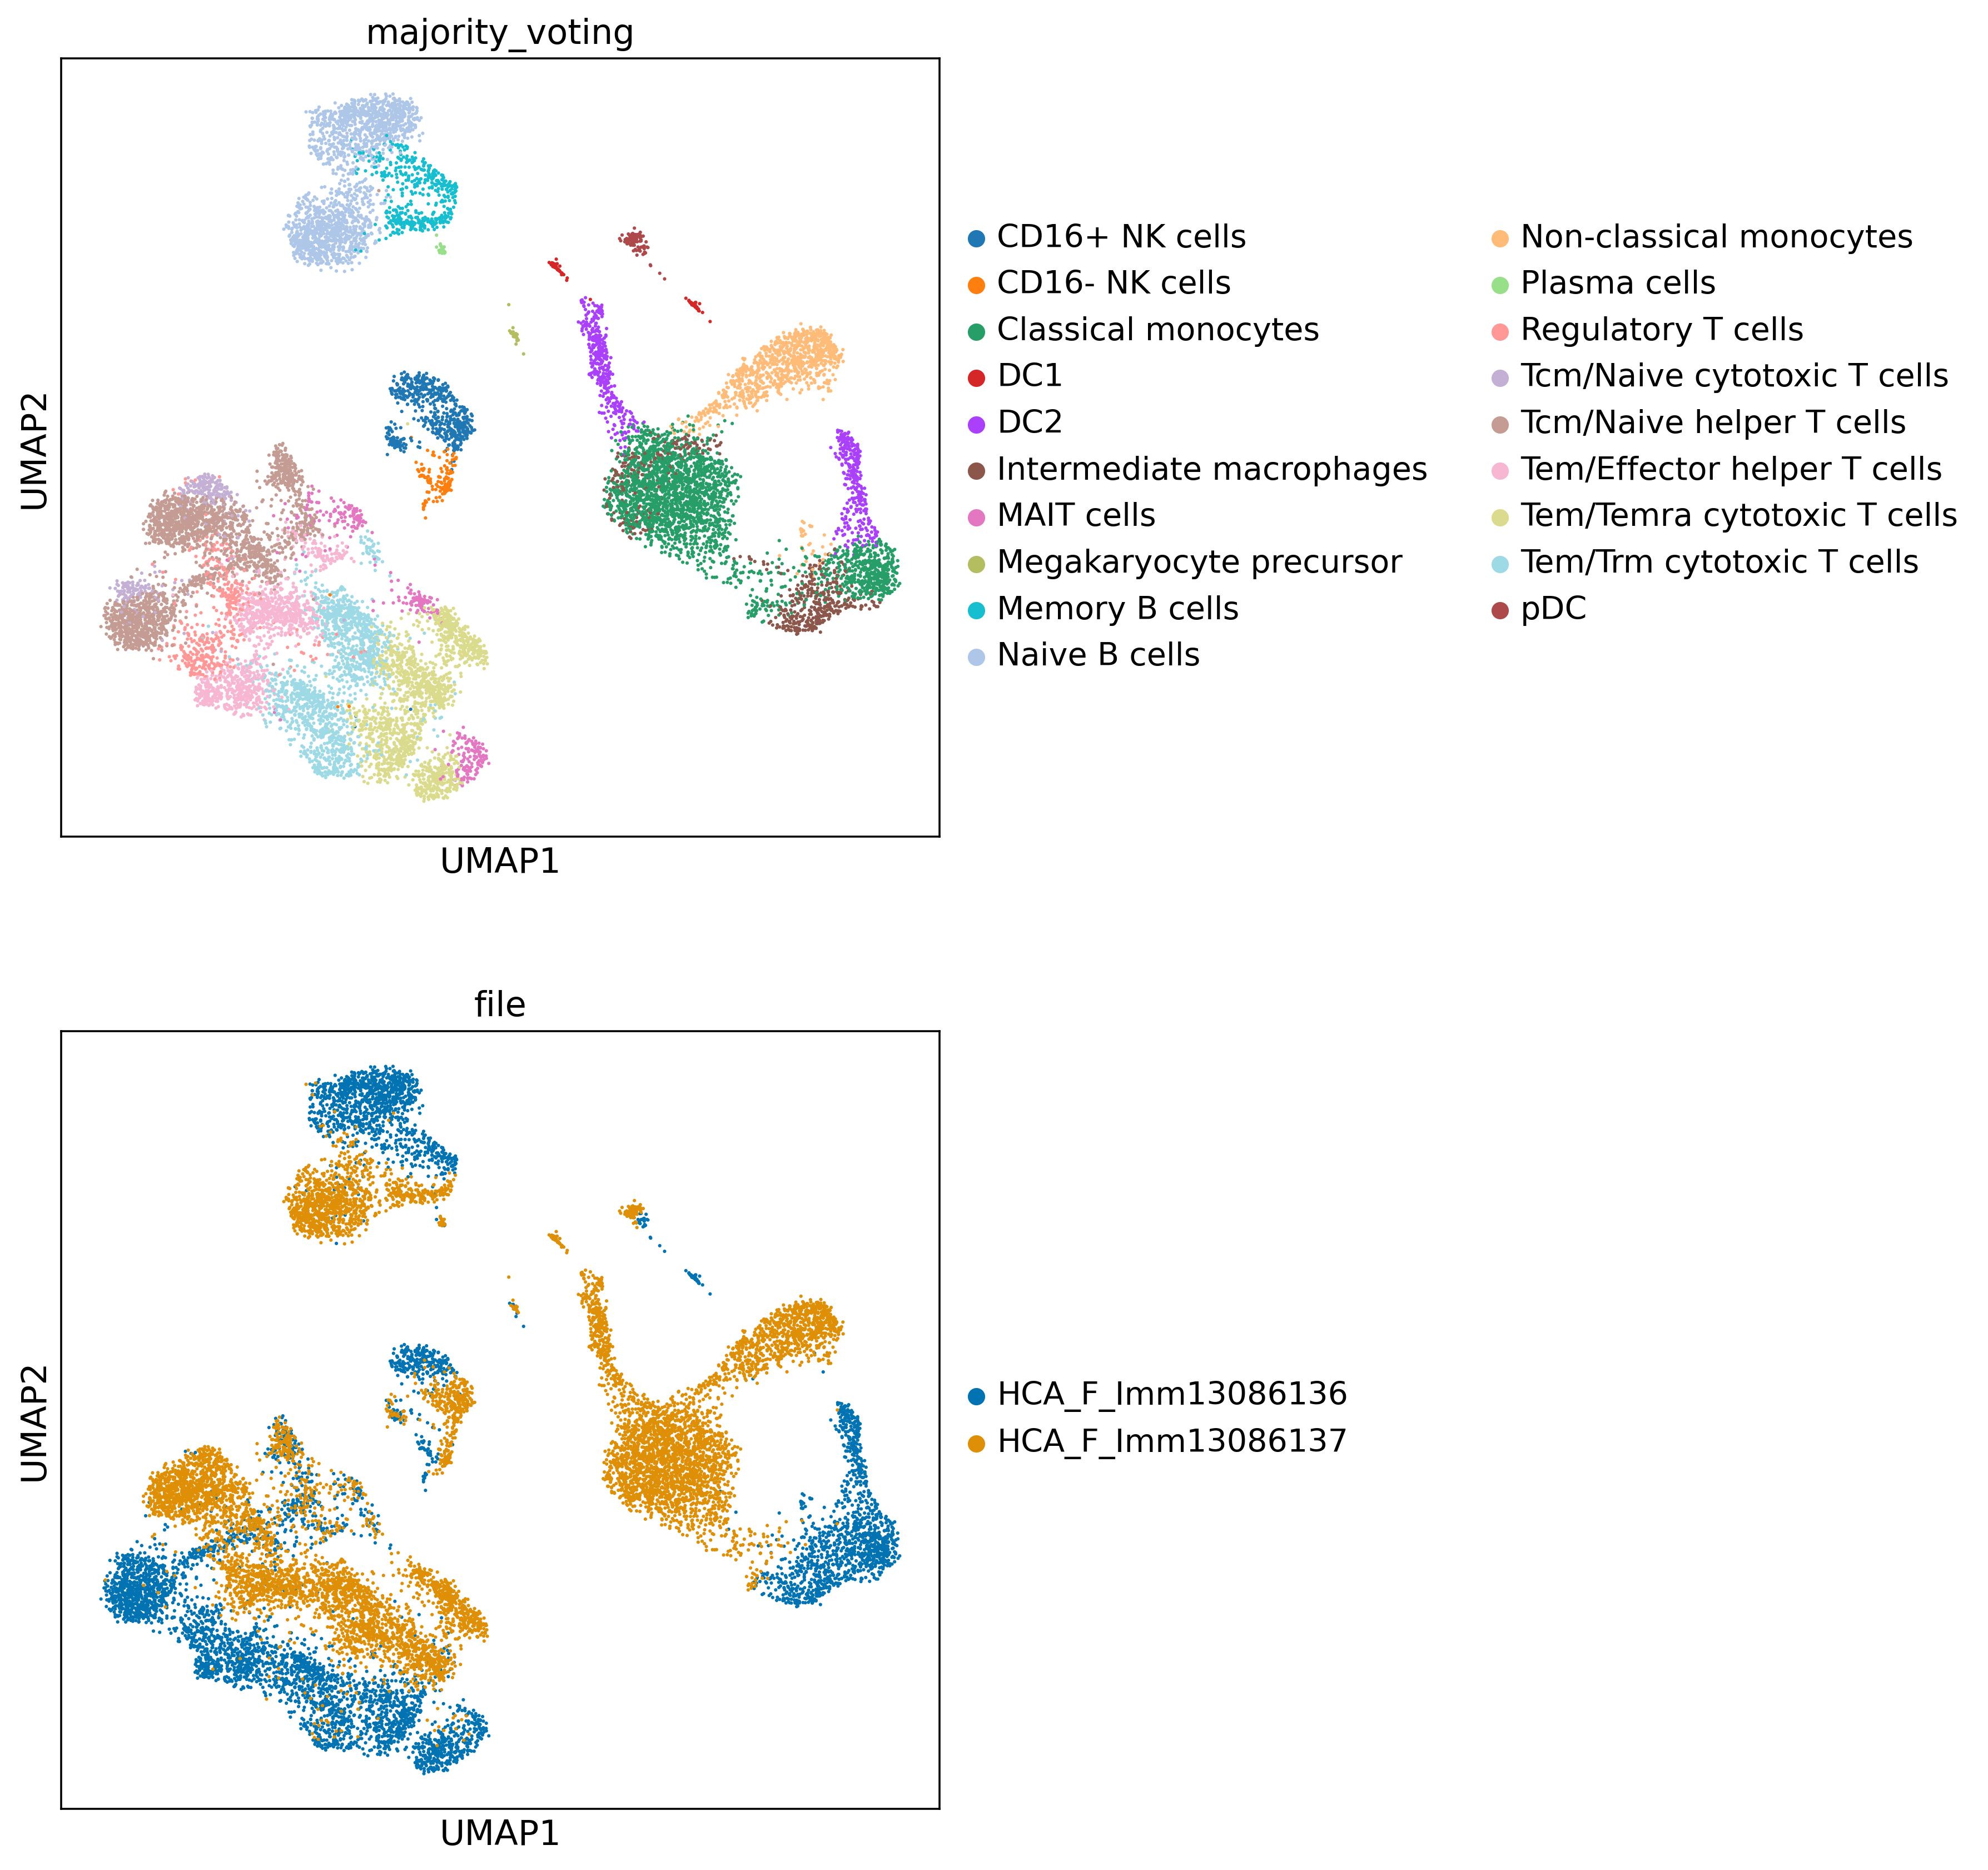

In [7]:
sc.pl.umap(adata, color=['majority_voting','file'],legend_loc='right margin',ncols=1)

In [8]:
adata.write_h5ad('write/PBMC_cycloheximide_predictions_compressed.h5ad', compression = 'gzip')